Подключаем нужные пакеты

In [85]:
from typing import Tuple, Optional
import numpy as np
from skimage.morphology import binary_closing
from scipy.ndimage import binary_fill_holes
from scipy.ndimage import rotate
from skimage.feature import canny
import cv2
import matplotlib.pyplot as plt

Подключаем библиотку с алгоритмом

In [86]:
from intelligent_placer_lib.intelligent_placer import *

Путь до файла:

In [87]:
path = "data/yes/test18.jpg"

Для начала получим контуры листа и многоугольника. </br>
Контур листа должен быть помечен красным цветом, многоугольника - зеленым

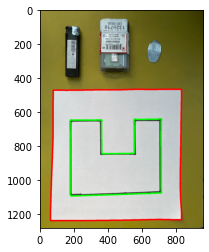

In [88]:
image = cv2.imread(path)
polygon_contours, paper_contours = find_paper_and_polygon_contours(path)
cv2.drawContours(image, [paper_contours], 0, (255, 0, 0), 8)
cv2.drawContours(image, [polygon_contours], 0, (0, 255, 0), 8)
plt.imshow(image)

Далее нам нужно найти контуры предметов. <br/>
Так как по постановке задачи предметы всегда находятся выше листа бумаги, то найдем самую верхнюю координату листа:

In [89]:
min_paper_y = min(paper_contours, key=lambda coordinates: coordinates[0][1])[0][1]
print(min_paper_y)

465


И обрежем изображение по этой координате

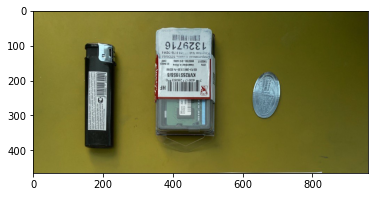

In [90]:
objects_image = cv2.imread(path)[:min_paper_y, :]
plt.imshow(objects_image)

Теперь будет легче определять предметы.
Далее найдём контуры предметов

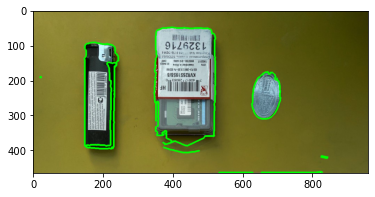

In [91]:
contours = find_all_contours(objects_image)
objects = list(contours[0])
cv2.drawContours(objects_image, objects, -1, (0, 255, 0), thickness=4)
plt.imshow(objects_image)

Видно, что есть шумы при определение контуров объектов, но далее они не будут использоваться при поиске масок для объектов

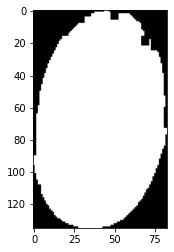

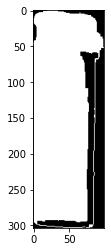

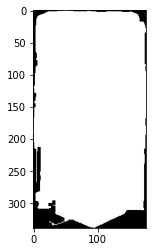

In [92]:
(h, w, d) = image.shape
object_masks_with_areas = get_objects_masks_with_areas(path, paper_contours)
for object_mask, _ in object_masks_with_areas:
    plt.imshow(object_mask)
    plt.gray()
    plt.show()

Мы получили маски предметов. Далее получим по контуру многоугольника его маску

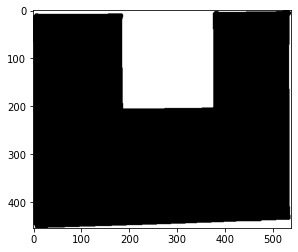

In [93]:
polygon_mask = create_mask_from_contours(polygon_contours)
plt.imshow(polygon_mask)
plt.gray()
plt.show()

Теперь у нас есть маски предметов и многоугольника. Алгоритм укладки выглядит следующим образом:<br/>
- Для начала отсортируем маски предметов по их площадям, чтобы сначала пытаться разместить самый большой предмет
- Маска многоугольника заполнена значениями 0(False), а маски предметов - значениями 1(True)
- Расширим область многоугольника влево, вправо, вверх и вниз значениями 1(True), чтобы далее не было проблем при повороте предмета и накладывании его на многоугольник
- Вычислим позиции начала многоугольника относительно уже расширенной области
- Будем пытаться идти по всем доступным x и y многоугольника, и для каждой такой позиции будем разворачивать предмет от 0 до 360 градусов с шагом 20
- С помощью битовой операции AND можно найти те области, которые пересекаются с уже помещенными предметами или с областью вне многугольника
- Для укладки была использована бинарная операция XOR
- Если хоть один предмет не получилось уложить, то возвращаем False, а если получилось все - True

In [94]:
sorted_object_masks_with_areas = sorted(object_masks_with_areas, key=lambda tup: tup[1], reverse=True)

In [95]:
def fit_objects(sorted_object_masks_with_areas):
    extended_polygon_mask = np.ones(np.asarray(polygon_mask.shape) * 2)
    polygon_mask_h, polygon_mask_w = polygon_mask.shape
    start_pos_y, start_pos_x = np.asarray(extended_polygon_mask.shape) // 2 - np.asarray(polygon_mask.shape) // 2
    extended_polygon_mask[start_pos_y:start_pos_y + polygon_mask_h, start_pos_x:start_pos_x + polygon_mask_w] = polygon_mask
    
    plt.imshow(extended_polygon_mask)
    plt.show()

    for object_mask, _ in sorted_object_masks_with_areas:
        if not try_to_fit_object(extended_polygon_mask, object_mask, start_pos_x, start_pos_y):
            return False

    return True

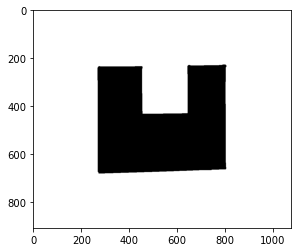

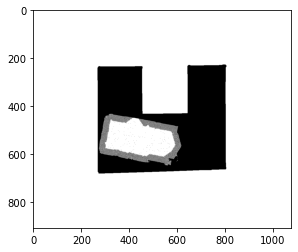

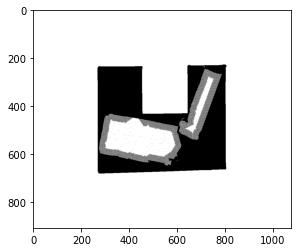

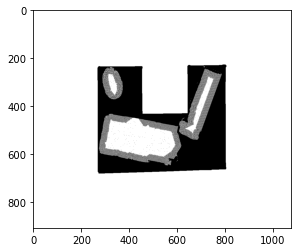

True

In [96]:
fit_objects(sorted_object_masks_with_areas)